# 0. Setup

In [21]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
from Scripts.utils.convenience_utils import get_example_data, plot_true_graph, get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance, plot_graph_sizes
import yaml

import warnings
warnings.filterwarnings("ignore")
CONFIG = 'pipeline_config.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Pipeline configurations

The configurations for the entire pipeline are defined under pipeline_config.yml. 

In [22]:
with open(CONFIG, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

### Telegram notification bot

In [3]:
import requests
import json
# from datetime import datetime

def send_telegram_message(message: str,
                          chat_id: str,
                          api_key: str,
                         ):
    responses = {}

    url = f'https://api.telegram.org/bot{api_key}/sendMessage?chat_id={chat_id}&text={message}'
    
    response = requests.post(url)
    
    return response

In [4]:
chat_id = "5027012918"
api_key = "6268687426:AAE1P7WQofCBuQPiYZlYaKU-p1GNn6OvAxM"

send_telegram_message("======================", chat_id, api_key)

send_telegram_message("Starting.", chat_id, api_key)

<Response [200]>

# 1. Train Metric Learning

## What it does
Broadly speaking, the first stage of our pipeline is embedding the space points on to graphs, in a way that is efficient, i.e. we miss as few points on a graph as possible. We train a MLP to transform the input feature vector of each space point $\mathbf{u}_i$ into an N-dimensional latent space $\mathbf{v}_i$. The graph is then constructed by connecting the space points whose Euclidean distance between the latent space points $$d_{ij} = \left| \mathbf{v}_i - \mathbf{v}_j \right| < r_{embedding}$$

## Training data
Let us take a look at the data before training. In this example pipeline, we have preprocessed the TrackML data into a more convenient form. We calculated directional information and summary statistics from the charge deposited in each spacepoints, and append them to its cyclidrical coordinates. Let us load an example data file and inspect the content.

In [5]:
example_data_df, example_data_pyg = get_example_data(configs)
example_data_df

0         1         2
0     0.012028  0.028858 -0.274359
1     0.012028  0.028858 -0.274359
2     0.012028  0.028858 -0.274359
3     0.012028  0.028858 -0.274359
4     0.033978  0.029188 -0.000641
...        ...       ...       ...
9445  0.010552  0.984742  0.688141
9446  0.010552  0.984742  0.688141
9447  0.010552  0.984742  0.688141
9448  0.045154  0.990266  0.636859
9449  0.045154  0.990266  0.636859

[9450 rows x 3 columns]

In [6]:
plot_true_graph(example_data_pyg, num_tracks=80)

## Train metric learning model

Finally we come to model training. By default, we train the MLP for 30 epochs, which takes approximately 15 minutes on an NVidia V100. Feel free to adjust the epoch number in pipeline_config.yml

In [7]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0


In [8]:
! nvidia-smi

Thu Feb 16 23:50:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    On   | 00000000:5E:00.0 Off |                  N/A |
| 41%   29C    P8    10W / 280W |   1537MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
send_telegram_message('Started metric learning training.', chat_id, api_key)

metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)

send_telegram_message('Finished metric learning training.', chat_id, api_key)

INFO:-------------------- Step 1: Running metric learning training --------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.694    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([2, 4292])
torch.Size([4292])
torch.Size([2, 182])
torch.Size([2, 12368])
torch.Size([12368])
torch.Size([2, 532])


Training: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/queues.py", l

    if w.is_alive():
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f57f15bf3a0>
Traceback (most recent call last):
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/fgias/.conda/envs/exatrkx/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f57f15bf3a0>
Trac

## Plot training metrics

We can examine how the training went. This is stored in a simple dataframe:

In [10]:
embedding_metrics = get_training_metrics(metric_learning_trainer)
embedding_metrics

epoch  train_loss  val_loss       eff       pur  current_lr
0       0    0.008565  0.009941  0.754168  0.003514    0.000012
1       1    0.008549  0.009940  0.695476  0.003456    0.000025
2       2    0.008525  0.009939  0.722052  0.003635    0.000038
3       3    0.008498  0.009937  0.722040  0.003867    0.000035
4       4    0.008486  0.009935  0.720435  0.004101    0.000063
5       5    0.008478  0.009932  0.795259  0.004320    0.000075
6       6    0.008465  0.009935  0.710408  0.004180    0.000087
7       7    0.008442  0.009933  0.825369  0.004318    0.000070
8       8    0.008434  0.009936  0.792545  0.004112    0.000070
9       9    0.008427  0.009936  0.788730  0.004097    0.000070
10     10    0.008422  0.009935  0.819327  0.004207    0.000070
11     11    0.008416  0.009935  0.807760  0.004283    0.000049
12     12    0.008408  0.009937  0.787354  0.004088    0.000049
13     13    0.008400  0.009936  0.801828  0.004254    0.000049
14     14    0.008400  0.009935  0.783890  0.004285    0.000049
15     15    0.008391  0.009935  0.795382  0.004281    0.000034
16     16    0.008388  0.009938  0.804176  0.004142    0.000034
17     17    0.008386  0.009937  0.811609  0.004177    0.000034
18     18    0.008387  0.009936  0.797816  0.004289    0.000034

In [11]:
plot_training_metrics(embedding_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [12]:
plot_neighbor_performance(metric_learning_model)

## Plot example truth and predicted graphs

In [13]:
plot_predicted_graph(metric_learning_model)

## Track lengths

In [14]:
plot_track_lengths(metric_learning_model)

100%|██████████| 80/80 [00:15<00:00,  5.02it/s]


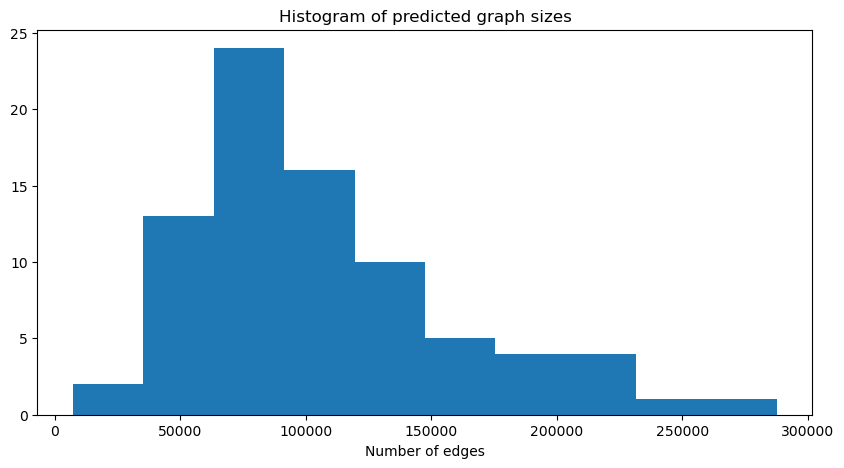

In [15]:
plot_graph_sizes(metric_learning_model)

# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network. Optionally, we also clear the directory.

In [16]:
graph_builder = run_metric_learning_inference(CONFIG)

INFO:------------- Step 2: Constructing graphs from metric learning model -------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------


Training finished, running inference to build graphs...


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


# 3. Train graph neural networks

We have a set of graphs constructed. We now train a GNN to classify edges as either "true" (belonging to the same track) or "false" (not belonging to the same track). We train for 30 epochs, which should take around 10 minutes on a V100 GPU. Your mileage may vary.

In [23]:
send_telegram_message('Started GNN training.', chat_id, api_key)

gnn_trainer, gnn_model = train_gnn(CONFIG)

send_telegram_message('Finished GNN training.', chat_id, api_key)

INFO:-------------------------  Step 3: Running GNN training  -------------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.0 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.397     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

INFO:-------------------------------- c) Saving model --------------------------------


<Response [200]>

## Plot training metrics

In [18]:
gnn_metrics = get_training_metrics(gnn_trainer)
gnn_metrics

FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/gnn/velo_data/version_12/metrics.csv'

In [ ]:
plot_training_metrics(gnn_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [ ]:
plot_edge_performance(gnn_model)

# Step 4: GNN inference 

In [ ]:
run_gnn_inference(CONFIG)

# Step 5: Build track candidates from GNN

In [ ]:
build_track_candidates(CONFIG)

# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%).
A discussion of each matching style and some worked examples can be found in the [Documentation](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/performance/matching_definitions/).

ATLAS style matching is the default.

In [ ]:
evaluated_events, reconstructed_particles, particles, matched_tracks, tracks = evaluate_candidates(CONFIG)

send_telegram_message('Finished evaluation.', chat_id, api_key)
send_telegram_message("======================", chat_id, api_key)